# Project 2 Part 4

In [1]:
#Full Name: Hannah Ploutz

## Project Overview

### Goals

Complete the Model Development phase for this project

### Tasks

- [X] Ensure that you complete the appropriate pre-processing steps.
- [X] Fit and evaluate multiple types of models on your data.
- [X] Evaluate each model with multiple appropriate metrics on BOTH the train and test data.
- [X] Use GridSearchCV to tune some of the hyperparameters of each model.
- [X] Display the metrics of your best tuned version of each model type.
- [X] Try feature engineering techniques or PCA to engineer your dataset to see how this impacts your modeling results. 
- [X] Choose your "production" model and justify this decision using the metrics most important to your business problem.
- [X] Go back through your code and ensure that you have provided clear comments

### Data Dictionary

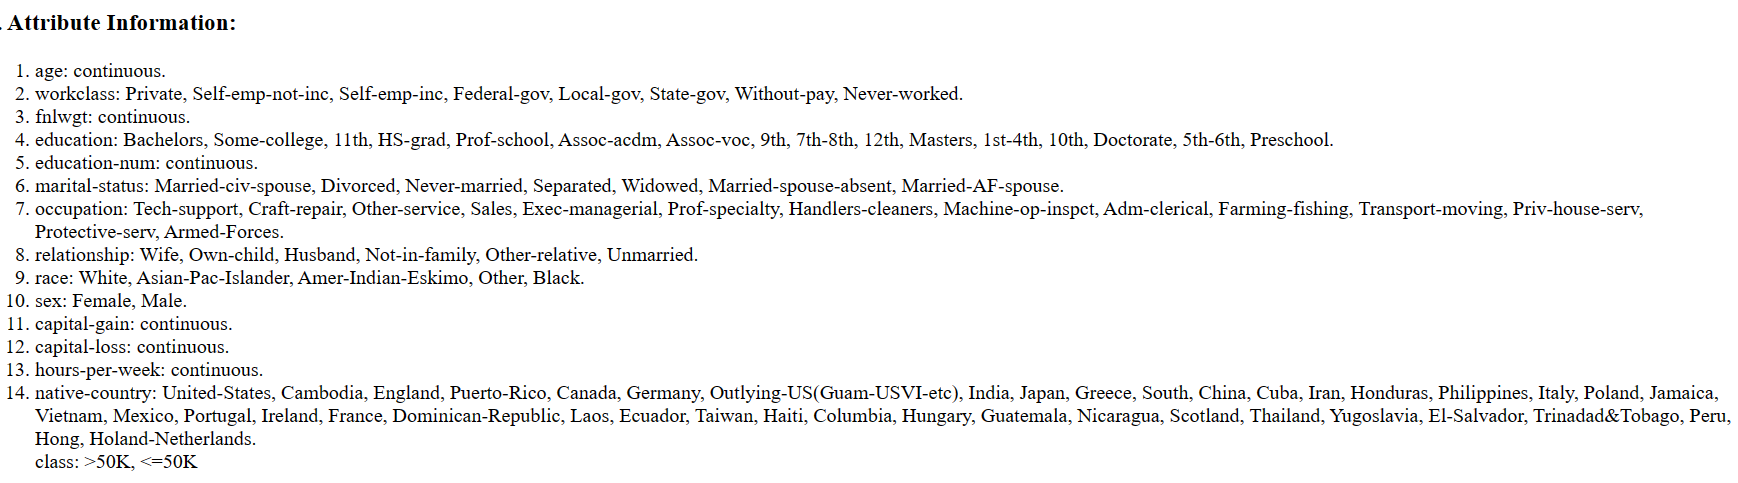

### Import Libraries

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

### Function

In [128]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens', thresh=.5): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_proba = model.predict_proba(X_test)
    y_pred = [1 if x[1] > thresh else 0 for x in y_proba]
    
    ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()
    

## Load and Inspect the Data

In [129]:
## Load the data
path = 'C:/Users/hgplo/iCloudDrive/Programming/Coding Dojo/Course 2/Project 2/adult.csv'
adult = pd.read_csv(path)

In [130]:
## Display the first (5) rows of the dataframe
adult.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [131]:
## Display the number of rows and columns for the dataframe
adult.shape
print(f'There are {adult.shape[0]} rows, and {adult.shape[1]} columns.')

There are 48842 rows, and 15 columns.


In [132]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [133]:
#Datatypes of each variable in the data set
data_types = adult.dtypes
object_data_types = (data_types == "object").sum()
int_data_types = (data_types == "int64").sum()

print(f'There are {object_data_types} object columns and {int_data_types} integer columns')

There are 9 object columns and 6 integer columns


Upon initial inspection of the data, I will be deleting three columns. The first is fnlwgt, the second is Education and the third is relationship. 
- **"Fnlgwt"** This shows the number of units in the target population that the responding unit represents, 
> - which can vary due to it being a weight assigned by the Census Bureau
- **"Education"** is already represented in the educational_num column with the total number of years of education completed
- **"Relationship"** is already represented in the marital status column

## Clean the Data

**Delete Unnecessary Columns**

In [134]:
#dropping the columns outlined above from the dataframe
adult = adult.drop(['fnlwgt', 'education','relationship'], axis=1)

In [135]:
#confirming columns have been dropped using df.info to view all the columns and types
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   educational-num  48842 non-null  int64 
 3   marital-status   48842 non-null  object
 4   occupation       48842 non-null  object
 5   race             48842 non-null  object
 6   gender           48842 non-null  object
 7   capital-gain     48842 non-null  int64 
 8   capital-loss     48842 non-null  int64 
 9   hours-per-week   48842 non-null  int64 
 10  native-country   48842 non-null  object
 11  income           48842 non-null  object
dtypes: int64(5), object(7)
memory usage: 4.5+ MB


**Delete Duplicated Rows**

In [136]:
#Checking the dataframe for duplicates
adult.duplicated().sum()

7916

In [137]:
#dropping duplicate rows
adult.drop_duplicates(inplace=True)

In [138]:
#confirming duplicate rows have been dropped
adult.duplicated().sum()

0

**Address Missing Values**

In [139]:
#Looking at count of missing values by column
#There are no missing values in this dataframe
print(adult.isna().sum())

age                0
workclass          0
educational-num    0
marital-status     0
occupation         0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


`Upon further investigation below, there are missing values that will be adjusted so they can be displayed properly`

 **Identify and correct inconsistencies in data for categorical values**

In [140]:
#Create a variable to house the newly updated datatype for the dataframe, and a new object filter
data_types_new = adult.dtypes
object_data_types_new = (data_types == "object")

In [141]:
#Create variable that houses columns that are object types (categorical variables)
object_data_types_filter = data_types_new[(data_types == "object")]
object_data_types_filter

workclass         object
marital-status    object
occupation        object
race              object
gender            object
native-country    object
income            object
dtype: object

In [142]:
#Index of the the filter created in the previous step
object_data_types_filter.index

Index(['workclass', 'marital-status', 'occupation', 'race', 'gender',
       'native-country', 'income'],
      dtype='object')

`Looking at the following unique values for the object columns, I noticed that there are indeed missing values, indicated with  '?'.` <br>
`I will replace those values with "nan" so that they can be properly addressed later when preparing for machine learning`

In [143]:
#For loop to loop through the index of the object columns and display the unique values in each
for column in object_data_types_filter.index:
    print(column)
    print(adult[column].unique())
    print('\n')

workclass
['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']


marital-status
['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']


occupation
['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']


race
['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']


gender
['Male' 'Female']


native-country
['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti' 'El-Salvador'
 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India' 'Cambodia'
 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada' 'Portugal'
 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica' 'Ecuador'
 'Yugoslavia' '

In [144]:
#replace all ? values in the dataframe with the numpy NaN value
adult.replace('?', np.nan, inplace=True)

In [145]:
#Printing the missing values now that they can be seen
print(adult.isna().sum())

age                   0
workclass          2324
educational-num       0
marital-status        0
occupation         2334
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      850
income                0
dtype: int64


In [146]:
#% of missing values per column
print(adult.isna().sum()/len(adult)*100)

age                0.000000
workclass          5.678542
educational-num    0.000000
marital-status     0.000000
occupation         5.702976
race               0.000000
gender             0.000000
capital-gain       0.000000
capital-loss       0.000000
hours-per-week     0.000000
native-country     2.076919
income             0.000000
dtype: float64


`The rest of the categorical columns look good, no need to adjust any typos`

**Identify outliers**

In [147]:
#Numerical statistics for all the numerical columns
adult.describe()

,age,educational-num,capital-gain,capital-loss,hours-per-week
count,40926.000000,40926.000000,40926.000000,40926.000000,40926.000000
mean,39.871549,10.105068,1272.336998,103.572790,40.747520
std,13.757406,2.689940,8075.900501,436.534106,13.035402
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,29.000000,9.000000,0.000000,0.000000,38.000000
50%,38.000000,10.000000,0.000000,0.000000,40.000000
75%,49.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


`Upon reviewing the numerical data, there doesn't appear to be any outliers or negative numbers`

## Univariate Visualization

**Produce univariate visuals for the target and all features.**

In [148]:
#Viewing the info from the dataframe to get the names of the columns
adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40926 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              40926 non-null  int64 
 1   workclass        38602 non-null  object
 2   educational-num  40926 non-null  int64 
 3   marital-status   40926 non-null  object
 4   occupation       38592 non-null  object
 5   race             40926 non-null  object
 6   gender           40926 non-null  object
 7   capital-gain     40926 non-null  int64 
 8   capital-loss     40926 non-null  int64 
 9   hours-per-week   40926 non-null  int64 
 10  native-country   40076 non-null  object
 11  income           40926 non-null  object
dtypes: int64(5), object(7)
memory usage: 4.1+ MB


Text(0.5, 1.0, 'Distribution of Income')

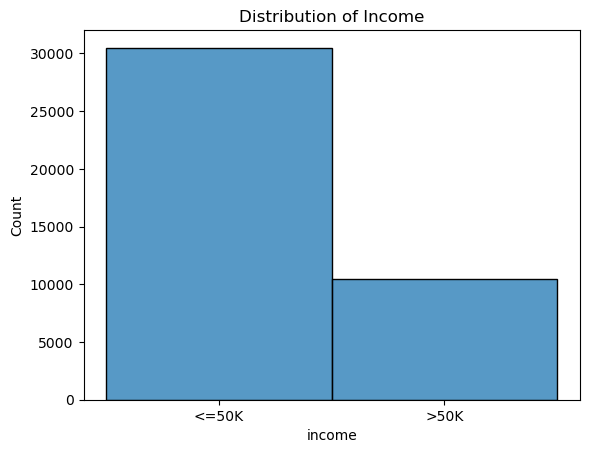

In [149]:
## Define a MatplotLib ax object using seaborn.histplot()
ax = sns.histplot(data=adult,
                  x='income',
                  bins=5)
## Set the Title
ax.set_title('Distribution of Income')

`After reviewing the above graph for the target variable,` <br>
`there are a greater distribution of <=50k Income compared to >50k Income`

### **Continuous Numeric Univariate Visuals**

**income v age**

Text(0.5, 1.0, 'Distribution of Age')

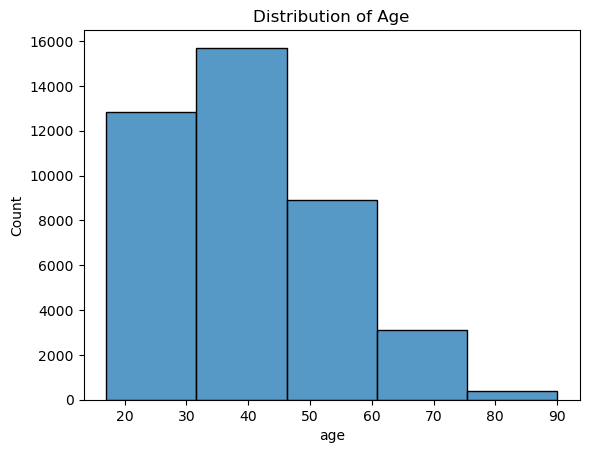

In [150]:
## Define a MatplotLib ax object using seaborn.histplot()
ax = sns.histplot(data=adult,
                  x='age',
                  bins=5)
## Set the Title
ax.set_title('Distribution of Age')

`After reviewing the above graph, there seems to be a higher distribution of income levels in age 20, 30 and 40,` <br>
`The highest amount of income level count is in between the ages of 30-40` <br>

**income v educational-num**

Text(0.5, 1.0, 'Distribution of Education Levels')

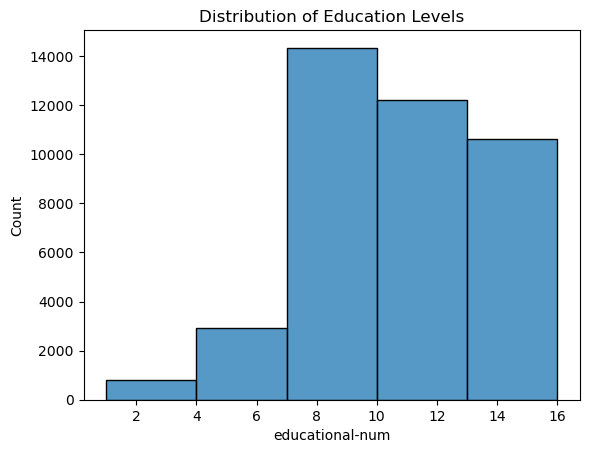

In [151]:
## Define a MatplotLib ax object using seaborn.histplot()
ax = sns.histplot(data=adult,
                  x='educational-num',
                  bins=5)
## Set the Title
ax.set_title('Distribution of Education Levels')

`After reviewing the above graph there is a higher distribution of income levels at 8 and 10 years of highest educational level achieved` <br>
`Some of the lowest distributions are 2 and 4 years` <br>

**income v capital gain**

Text(0.5, 1.0, 'Distribution of Capital Gain')

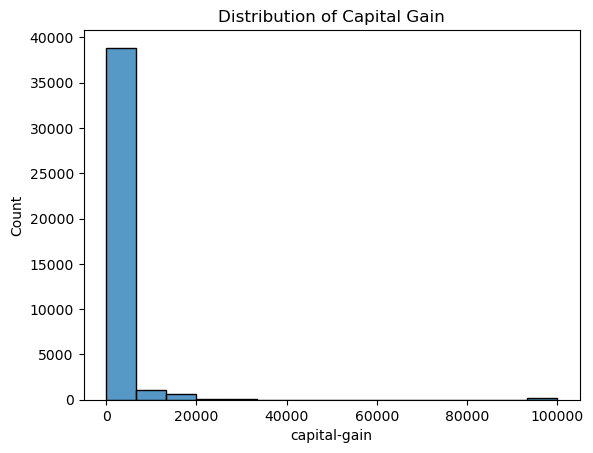

In [152]:
## Define a MatplotLib ax object using seaborn.histplot()
ax = sns.histplot(data=adult,
                  x='capital-gain',
                  bins=15)
## Set the Title
ax.set_title('Distribution of Capital Gain')

`After reviewing the above graph, there is a large amount of distribution of capital gain in the 0 - 5000 range for income levels` <br>

**income v capital loss**

Text(0.5, 1.0, 'Distribution of Capital Loss')

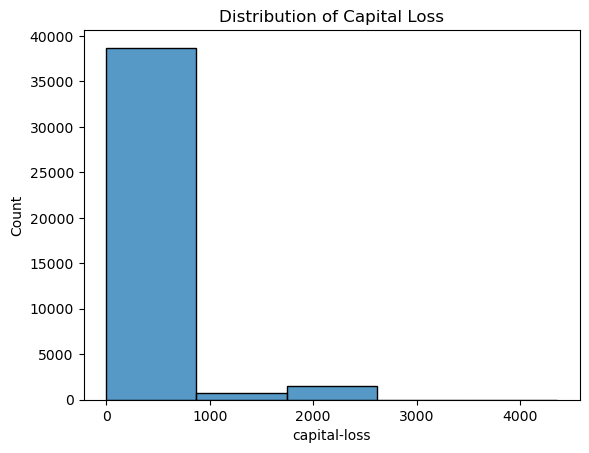

In [153]:
## Define a MatplotLib ax object using seaborn.histplot()
## Bins = 5
ax = sns.histplot(data=adult,
                  x='capital-loss',
                  bins=5)
## Set the Title
ax.set_title('Distribution of Capital Loss')

`After reviewing the above graph, there is a large amount of distribution of capital loss in the 0 to 9000 range` <br>

**income v hours-per-week**

Text(0.5, 1.0, 'Distribution of Hours Per Week')

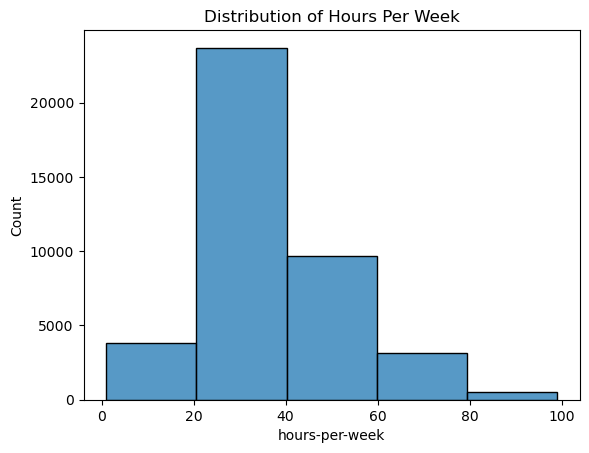

In [154]:
## Define a MatplotLib ax object using seaborn.histplot()
ax = sns.histplot(data=adult,
                  x='hours-per-week',
                  bins=5)
## Set the Title
ax.set_title('Distribution of Hours Per Week')

`After reviewing the above graph, there appears to be a greater amount of distribution of income levels between 20-30 hours per week` <br>

### **Categorical Univariate Visuals**

**income v workclass**

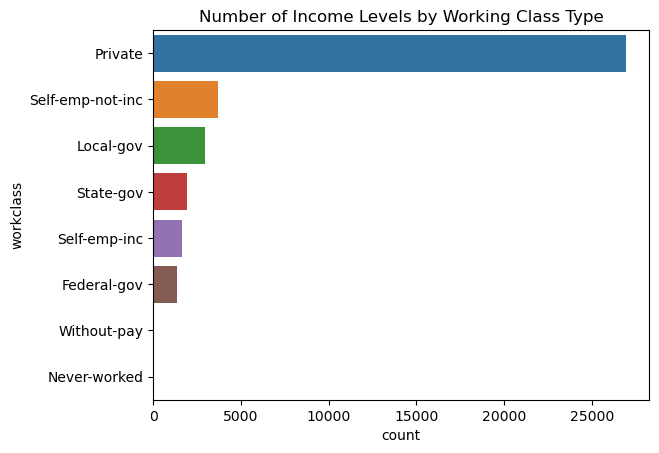

In [155]:
## Define the label order
label_order = adult['workclass'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   y='workclass',
                   order=label_order)

## Set the Title
ax.set_title('Number of Income Levels by Working Class Type');

`After reviewing this graph, it is clear that there is a very high count of income levels in the Private sector employees category` <br>

**income v marital-status**

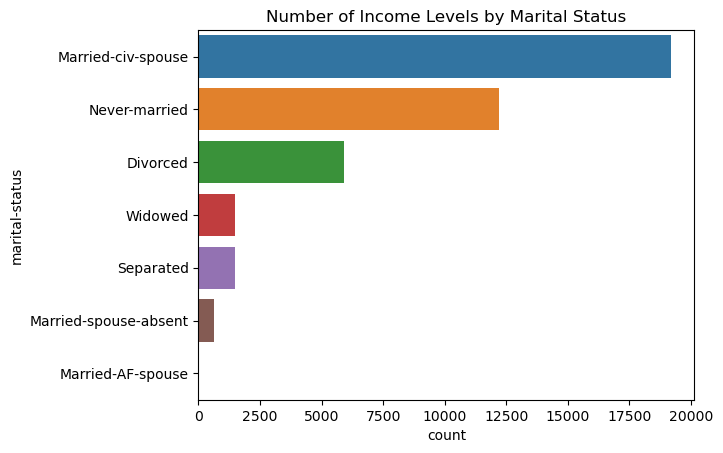

In [156]:
## Define the label order
label_order = adult['marital-status'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   y='marital-status',
                   order=label_order)

## Set the Title
ax.set_title('Number of Income Levels by Marital Status');

`After reviewing the above graph, there seems to be a large amount of income levels in Married-civ-spouse and` <br>
`Never-married categorys.` <br>

**income v occupation**

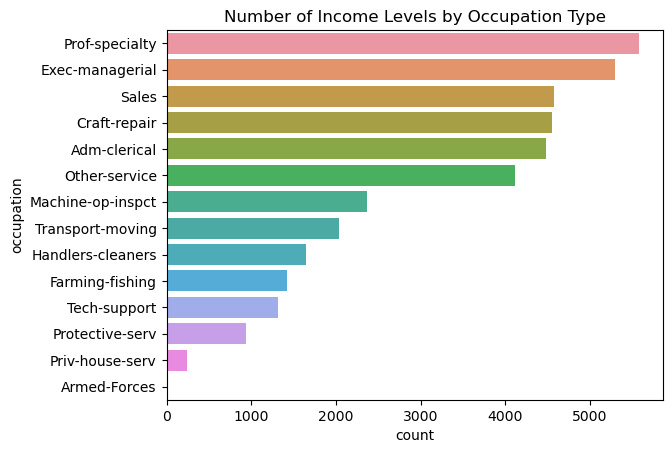

In [157]:
## Define the label order
label_order = adult['occupation'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   y='occupation',
                   order=label_order)

## Set the Title
ax.set_title('Number of Income Levels by Occupation Type');

`After reviewing this graph, there appears to be quite a large count of income levels in the Prof-speciality and Exec Management` <br>
`There is a moderate count of income levels in Sales, Craft-repair, Admin-clerical and Other Service` <br>
`While the least amount of counts are in the rest of the categories, with Armed Forces being the least with 0`

**income v race**

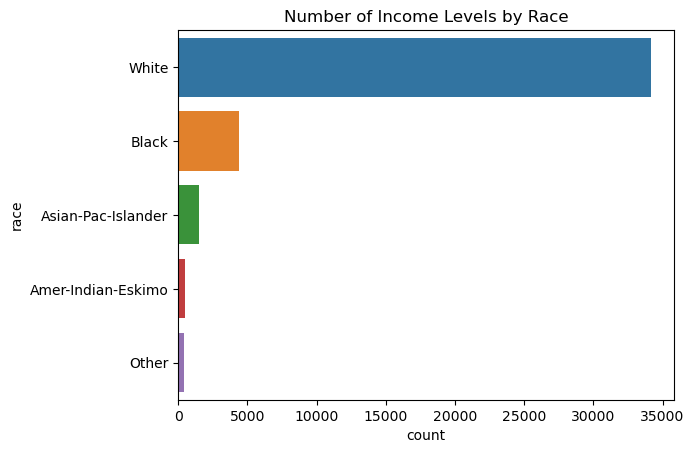

In [158]:
## Define the label order
label_order = adult['race'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   y='race',
                   order=label_order)

## Set the Title
ax.set_title('Number of Income Levels by Race');

`After reviewing this graph, it appears there is a larger distribution of income levels among those who have a White race.` <br>
`After that the count of income levels drop to very low levels`

**income v native country**

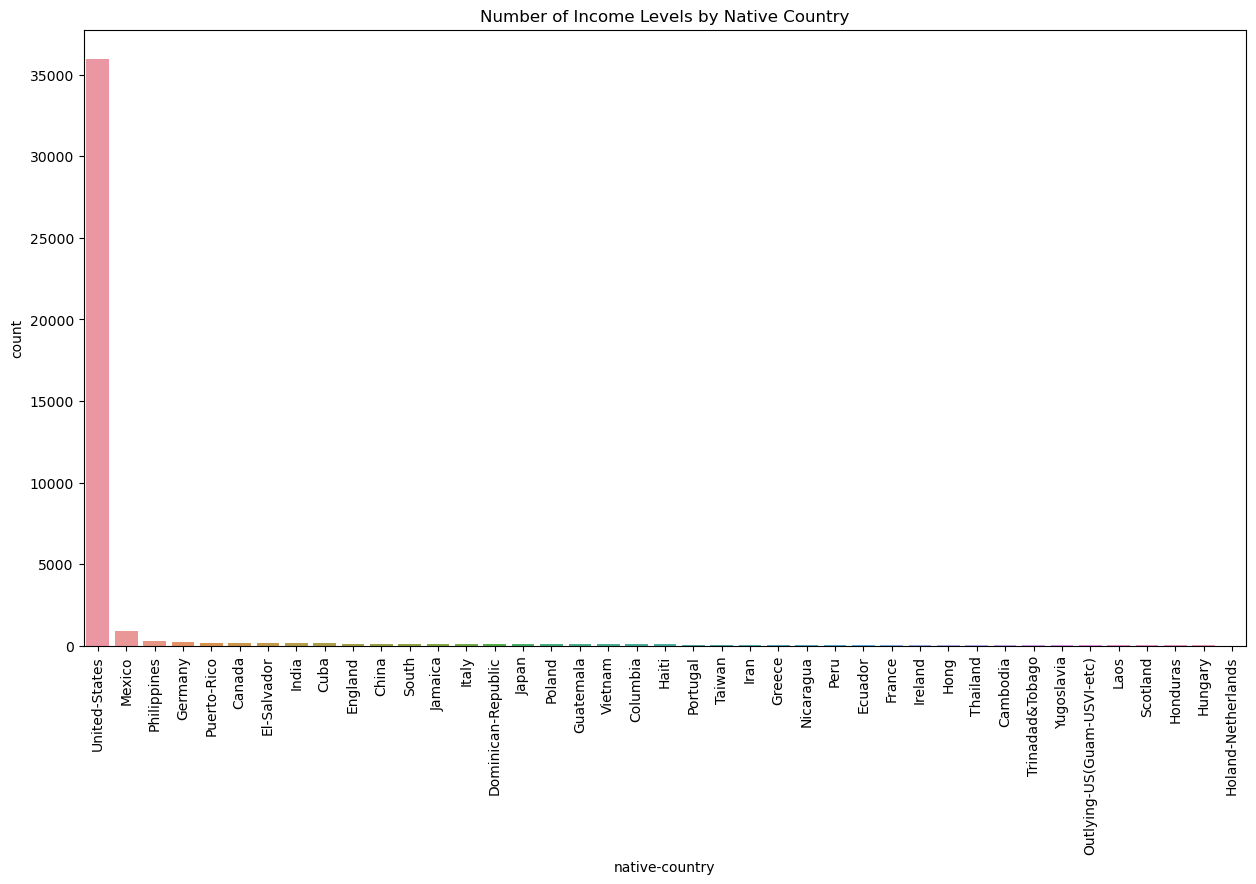

In [159]:
#set figure size to something bigger in order to see all the values
plt.figure(figsize=(15,8))

## Define the label order
label_order = adult['native-country'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   x='native-country',
                   order=label_order)
## Set the Title
ax.set_title('Number of Income Levels by Native Country')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

`^ Code source from` https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot <br>
`^ Code source from` https://drawingfromdata.com/seaborn/matplotlib/visualization/rotate-axis-labels-matplotlib-seaborn.html 

`After reviewing the graph, it appears that there are a lot of data points for United States, but very few to none for other Countrys`

**income v gender**

Text(0.5, 1.0, 'Number of Income Levels by Gender')

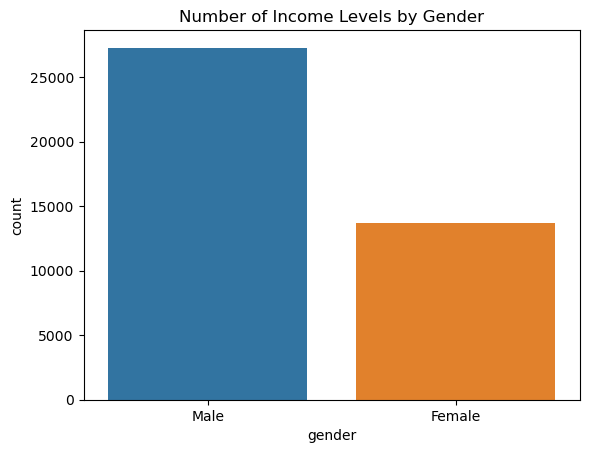

In [160]:
## Define the label order
label_order = adult['gender'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   x='gender',
                   order=label_order)
## Set the Title
ax.set_title('Number of Income Levels by Gender')

`After reviewing this graph, there is a larger count of income levels for Male and much less for Female genders` <br>

## Multivariate Visualization

### Correlation Heatmap

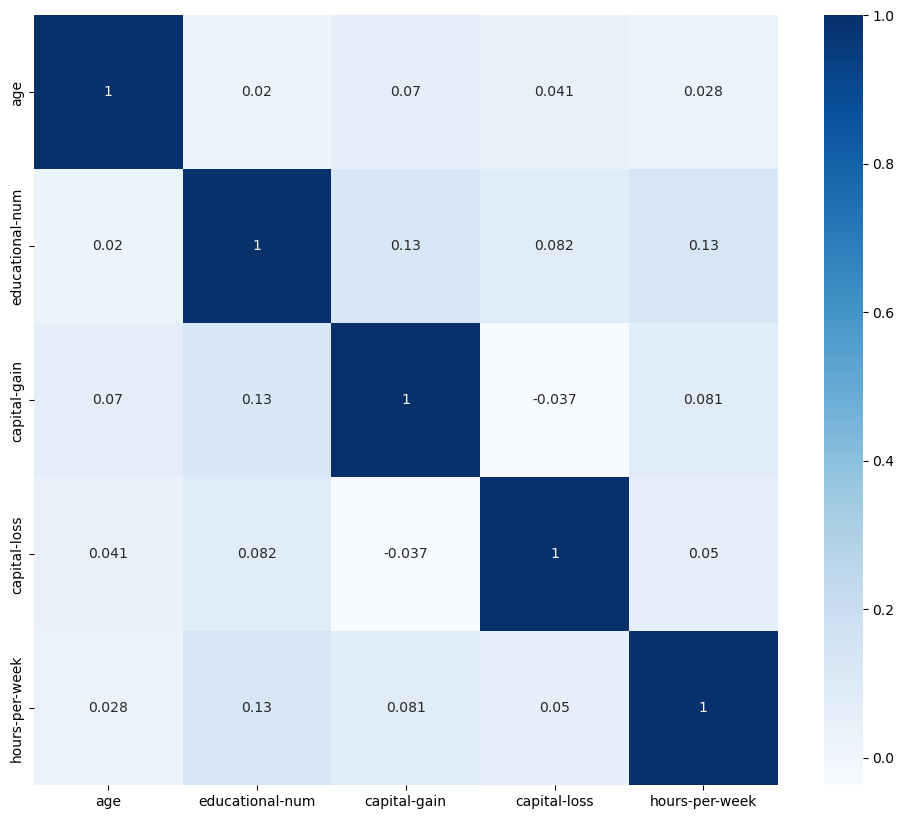

In [161]:
#df.corr to create a correlation of the numerical data, then creating a heatmap with Seaborn
corr = adult.corr()
fig, ax = plt.subplots(figsize = (12, 10))
ax = sns.heatmap(corr, cmap= 'Blues', annot = True)

`After reviewing the above correlation heatmap, there appears to be a small correlation between capital gain and education num with 0.13` <br>
`There is also a small correlation between educational num and hours per week with 0.13`

### Multivariate Barcharts

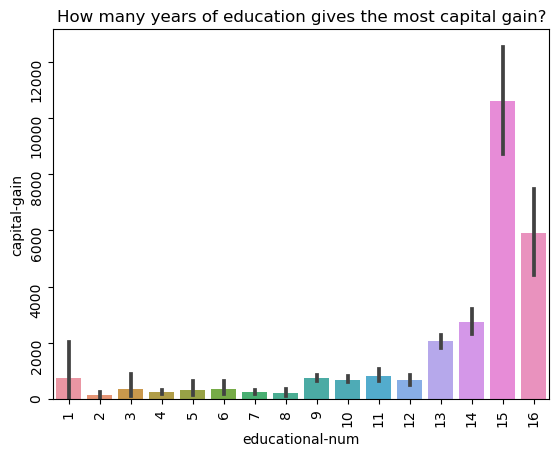

In [162]:
# Create barplot with seaborn
ax = sns.barplot(x= 'educational-num', y = 'capital-gain', data = adult)
ax.tick_params(rotation = 90)
ax.set_title('How many years of education gives the most capital gain?');

- There appears to be a slight correlation, the more years of education, the higher the capital gain
- However, there is a drop off in capital gain once 16 years of education is hit

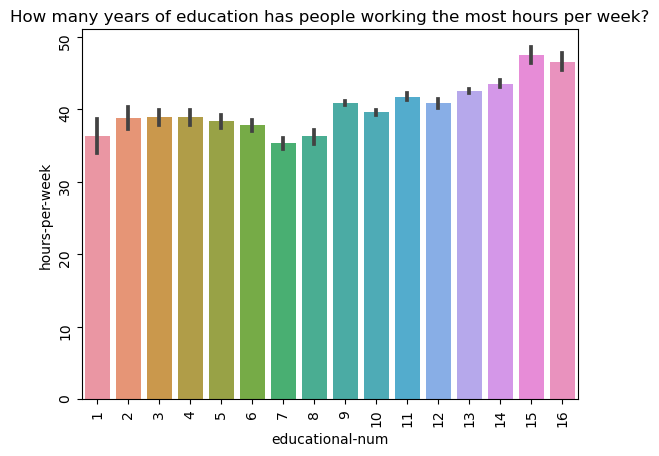

In [163]:
# Create barplot with seaborn
ax = sns.barplot(x= 'educational-num', y = 'hours-per-week', data = adult)
ax.tick_params(rotation = 90)
ax.set_title('How many years of education has people working the most hours per week?');

- There appears to be a slight correlation, the more years of education, the higher number of hours worked per week

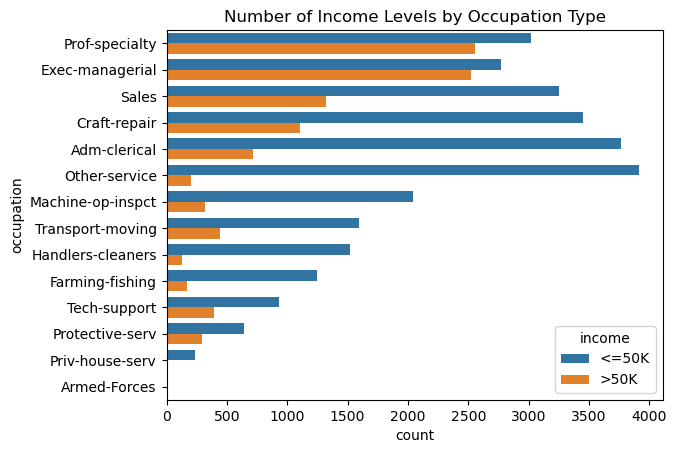

In [164]:
## Define the label order
label_order = adult['occupation'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   y='occupation',
                   order=label_order,
                  hue='income')

## Set the Title
ax.set_title('Number of Income Levels by Occupation Type');

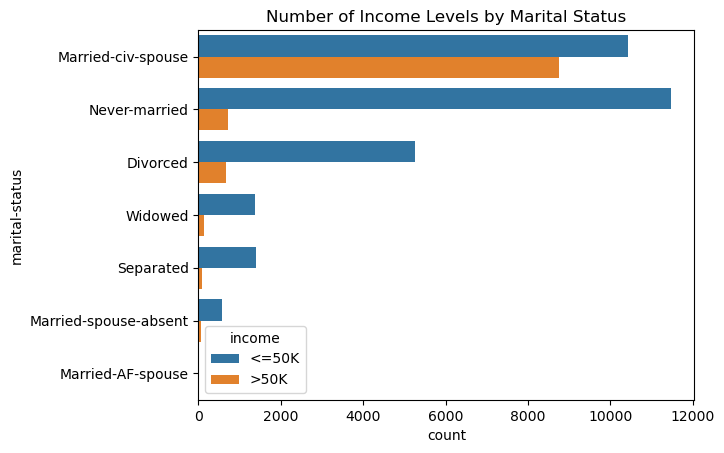

In [165]:
## Define the label order
label_order = adult['marital-status'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   y='marital-status',
                   order=label_order,
                  hue='income')

## Set the Title
ax.set_title('Number of Income Levels by Marital Status');

Text(0.5, 1.0, 'Number of Income Levels by Gender')

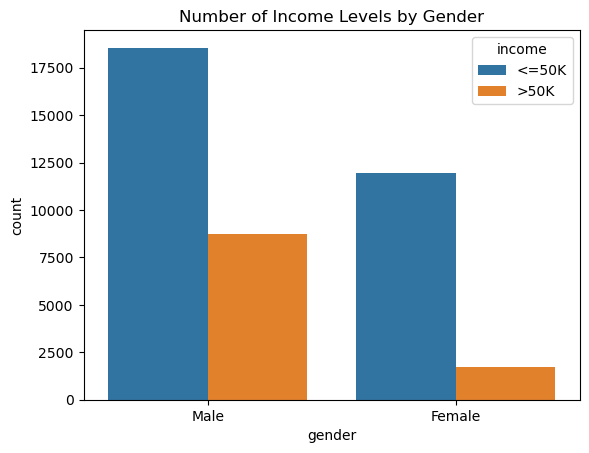

In [166]:
## Define the label order
label_order = adult['gender'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   x='gender',
                   order=label_order,
                  hue='income')
## Set the Title
ax.set_title('Number of Income Levels by Gender')

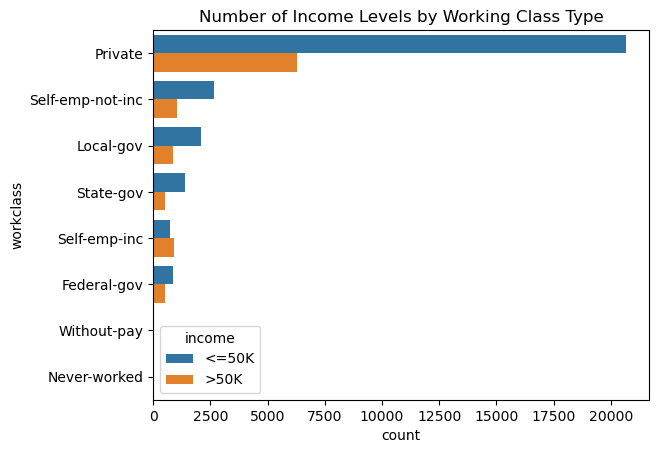

In [167]:
## Define the label order
label_order = adult['workclass'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   y='workclass',
                   order=label_order,
                  hue='income')

## Set the Title
ax.set_title('Number of Income Levels by Working Class Type');

## Stakeholder Visualizations

### Visualization #1

Text(0.5, 1.0, 'How many Years of Education Shows the Most Capital Gain?')

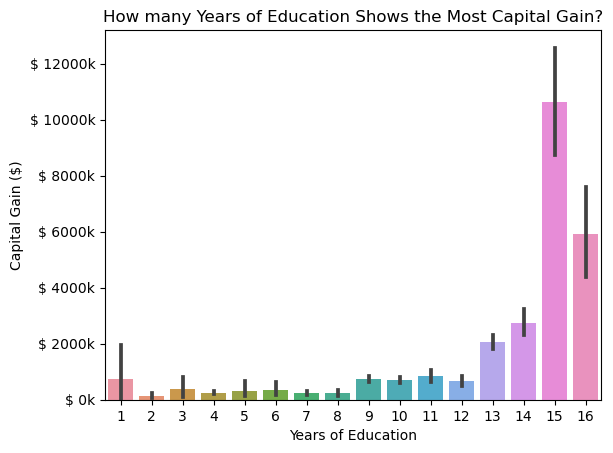

In [168]:
# Create barplot with seaborn
ax = sns.barplot(x='educational-num', y='capital-gain', data=adult)

# Set the x and y axis labels
ax.set_xlabel('Years of Education')
ax.set_ylabel('Capital Gain ($)')

# Set the format of the y-axis tick labels
formatter = ticker.FormatStrFormatter('$ %1.0fk')
ax.yaxis.set_major_formatter(formatter)

# Rotate the x-axis tick labels for better visibility
#ax.tick_params(rotation=0)


# Set the title
ax.set_title('How many Years of Education Shows the Most Capital Gain?')


- In the above graph, it clearly indicates that 15 years of education has the most capital gain
- Generally speaking, the more years of education, the higher the capital gain
- However, there is a drop off at 16 years of education where it drops down to 6000k

### Visualization #2

Text(0.5, 1.0, 'Which Gender Makes More Money?')

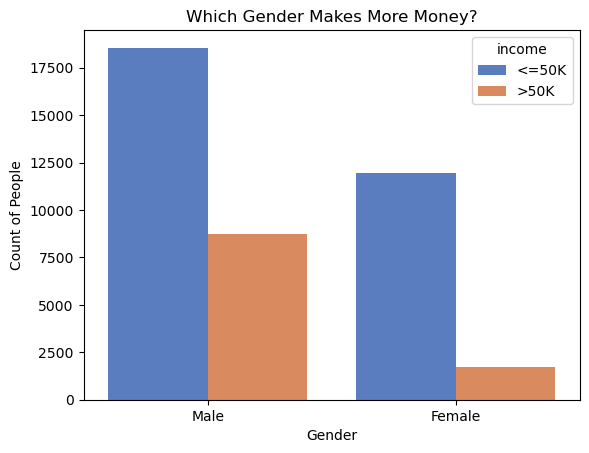

In [169]:
## Define the label order
label_order = adult['gender'].value_counts().index

## Define a MatplotLib ax (plot) object using seaborn.countplot()
ax = sns.countplot(data=adult,
                   x='gender',
                   order=label_order,
                  hue='income',
                  palette='muted')

# Set the x and y axis labels
ax.set_xlabel('Gender')
ax.set_ylabel('Count of People')


## Set the Title
ax.set_title('Which Gender Makes More Money?')

- In the above graph, it can be seen clearly that the Male gender appears to make more money than the Female
- There is also a highler count of >50k income level for Males, and lower count of >50k for Females

## Model Development Phase

### Data Clean Up

In [170]:
#Replace the <=50k and >50K in the income column with 0s and 1s
adult['income'].replace({'<=50K':1, '>50K':0}, inplace=True)

In the next few steps, I will identify which categorical values occur less than 3% of the time and remove those rows from the dataframe

In [171]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40926 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              40926 non-null  int64 
 1   workclass        38602 non-null  object
 2   educational-num  40926 non-null  int64 
 3   marital-status   40926 non-null  object
 4   occupation       38592 non-null  object
 5   race             40926 non-null  object
 6   gender           40926 non-null  object
 7   capital-gain     40926 non-null  int64 
 8   capital-loss     40926 non-null  int64 
 9   hours-per-week   40926 non-null  int64 
 10  native-country   40076 non-null  object
 11  income           40926 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 4.1+ MB


In [172]:
#For loop to loop through the index of the object columns and display the value counts in each as a %
for column in object_data_types_filter.index:
    print(column)
    print(adult[column].value_counts(normalize=True)*100)
    print('\n')

workclass
Private             69.755453
Self-emp-not-inc     9.639397
Local-gov            7.724988
State-gov            4.947930
Self-emp-inc         4.258847
Federal-gov          3.593078
Without-pay          0.054401
Never-worked         0.025905
Name: workclass, dtype: float64


marital-status
Married-civ-spouse       46.860187
Never-married            29.783023
Divorced                 14.462689
Widowed                   3.638274
Separated                 3.635831
Married-spouse-absent     1.529590
Married-AF-spouse         0.090407
Name: marital-status, dtype: float64


occupation
Prof-specialty       14.453773
Exec-managerial      13.728234
Sales                11.847015
Craft-repair         11.800373
Adm-clerical         11.616397
Other-service        10.668014
Machine-op-inspct     6.125622
Transport-moving      5.288661
Handlers-cleaners     4.275498
Farming-fishing       3.682110
Tech-support          3.422989
Protective-serv       2.433147
Priv-house-serv       0.619299
Arm

Upon analysis of the above, I will remove the following that are below 3% in occurance, in order to prepare my data for modeling:

- `workclass` - I will remove Never-worked, Without-pay
- `marital-status` - I will remove Married-AF-spouse, Married-spouse-absent
- `occupation` - I will remove Armed-Forces, Priv-house-serv and Protective-serv
- `race` - I will remove Other, Amer-Indian-Eskimo and Asian-Pac-Islander
- `native-country` - I will remove everything except United States

In [173]:
#removing the specified values based on a boolean indexing
values = ['Never-worked', 'Without-pay']
adult = adult[adult['workclass'].isin(values)==False]

In [174]:
#viewing the value counts fo the workclass column to ensure the changes have gone through
adult['workclass'].value_counts().sort_index()

Federal-gov          1387
Local-gov            2982
Private             26927
Self-emp-inc         1644
Self-emp-not-inc     3721
State-gov            1910
Name: workclass, dtype: int64

In [175]:
#removing the specified values based on a boolean indexing
values_marital = ['Married-AF-spouse', 'Married-spouse-absent']
adult = adult[adult['marital-status'].isin(values_marital)==False]

In [176]:
#removing the specified values based on a boolean indexing
values_occ = ['Armed-Forces', 'Priv-house-serv', 'Protective-serv']
adult = adult[adult['occupation'].isin(values_occ)==False]

In [177]:
#removing the specified values based on a boolean indexing
values_race = ['Other', 'Amer-Indian-Eskimo','Asian-Pac-Islander']
adult = adult[adult['race'].isin(values_race)==False]

In [178]:
#Keeping only the specified values based on a boolean indexing
values_country = ['United-States']
adult = adult[adult['native-country'].isin(values_country)==True]

In [179]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33451 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              33451 non-null  int64 
 1   workclass        31516 non-null  object
 2   educational-num  33451 non-null  int64 
 3   marital-status   33451 non-null  object
 4   occupation       31516 non-null  object
 5   race             33451 non-null  object
 6   gender           33451 non-null  object
 7   capital-gain     33451 non-null  int64 
 8   capital-loss     33451 non-null  int64 
 9   hours-per-week   33451 non-null  int64 
 10  native-country   33451 non-null  object
 11  income           33451 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 3.3+ MB


In [180]:
#For loop to loop through the index of the object columns and display the value counts in each as a %
for column in object_data_types_filter.index:
    print(column)
    print(adult[column].value_counts(normalize=True)*100)
    print('\n')

workclass
Private             69.412362
Self-emp-not-inc    10.353471
Local-gov            7.209037
State-gov            4.873715
Self-emp-inc         4.572281
Federal-gov          3.579134
Name: workclass, dtype: float64


marital-status
Married-civ-spouse    47.538190
Never-married         29.478939
Divorced              15.545126
Widowed                3.781651
Separated              3.656094
Name: marital-status, dtype: float64


occupation
Prof-specialty       15.011423
Exec-managerial      14.779794
Sales                12.714177
Craft-repair         12.035157
Adm-clerical         12.022465
Other-service        10.191649
Machine-op-inspct     5.889072
Transport-moving      5.705039
Handlers-cleaners     4.204214
Farming-fishing       3.769514
Tech-support          3.677497
Name: occupation, dtype: float64


race
White    88.80452
Black    11.19548
Name: race, dtype: float64


gender
Male      66.595916
Female    33.404084
Name: gender, dtype: float64


native-country
United-State

- Every categorical row that had an occurance of less than 3% was removed from the dataset

### Train Test and Split the Data

In [181]:
# Define target value y and features X
y = adult['income']
X = adult.drop(columns=['income'])

In [102]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [103]:
#Checking X_train first five rows to ensure the target column was dropped
X_train.head()

,age,workclass,educational-num,marital-status,occupation,race,gender,capital-gain,capital-loss,hours-per-week,native-country
24683,69,Private,13,Widowed,Prof-specialty,White,Male,0,2282,40,United-States
26043,27,Private,13,Never-married,Exec-managerial,White,Male,0,0,45,United-States
1137,24,Private,13,Never-married,Exec-managerial,White,Male,0,0,40,United-States
40480,59,Private,14,Widowed,Exec-managerial,White,Female,0,0,40,United-States
17665,37,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,White,Male,0,0,60,United-States


### Preprocessing for Machine Learning

Reviewing my data again, I have around 5% missing from the categorical column "workclass"<br>
As well as around 5% missing from the categorical column "occupation"

In [104]:
#% of missing values per column
print(adult.isna().sum()/len(adult)*100)
print('\n')
adult.info()

age                0.00000
workclass          5.78458
educational-num    0.00000
marital-status     0.00000
occupation         5.78458
race               0.00000
gender             0.00000
capital-gain       0.00000
capital-loss       0.00000
hours-per-week     0.00000
native-country     0.00000
income             0.00000
dtype: float64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33451 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              33451 non-null  int64 
 1   workclass        31516 non-null  object
 2   educational-num  33451 non-null  int64 
 3   marital-status   33451 non-null  object
 4   occupation       31516 non-null  object
 5   race             33451 non-null  object
 6   gender           33451 non-null  object
 7   capital-gain     33451 non-null  int64 
 8   capital-loss     33451 non-null  int64 
 9   hours-per-week   33451 non-null  int64 
 10  nativ

**ColumnSelector**

In [105]:
## Instantiate the numerical column selector
num_selector = selector(dtype_include='number')

In [106]:
## Instantiate the categorical column selector
cat_selector = selector(dtype_include='object')

**Imputers**

In [107]:
#instantiating the SimpleImputer and using the strategiy "most frequent" for the missing categorical values
imputer = SimpleImputer(strategy='most_frequent')

**Transformers**

In [108]:
## Instantiate the scaler transformer
scaler = StandardScaler()

In [109]:
# Instantiate the One Hot Encoder transformer
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

**Tuples**

In [110]:
number_tuple = (scaler, num_selector)

In [111]:
cat_tuple = (ohe, imputer, cat_selector)

**Preprocessor ColumnTransformer**

In [112]:
## Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
        ('num', scaler, num_selector),
        ('cat', make_pipeline(ohe, imputer), cat_selector),
])

In [113]:
#Knearest neighbor (+GridSearch), Random Forest (+GridSearch), PCA

### K-Nearest Neighbors

#### Default Model

In [114]:
## Create an instance of the model
knn = KNeighborsClassifier()
## Create a model pipeline
knn_pipe = make_pipeline(preprocessor, knn)
## Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      6678
           1       0.90      0.93      0.91     18410

    accuracy                           0.87     25088
   macro avg       0.84      0.82      0.83     25088
weighted avg       0.87      0.87      0.87     25088



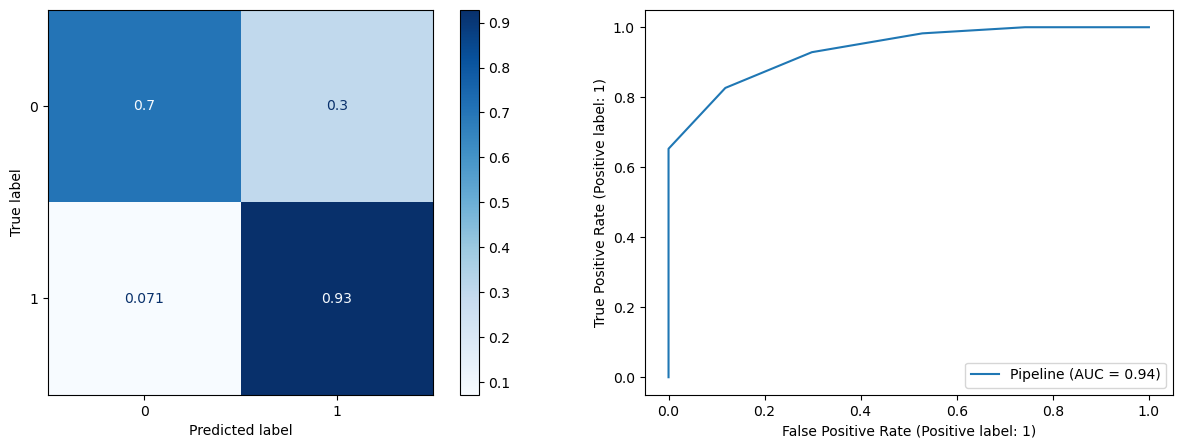

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      2250
           1       0.86      0.89      0.87      6113

    accuracy                           0.81      8363
   macro avg       0.76      0.74      0.75      8363
weighted avg       0.81      0.81      0.81      8363



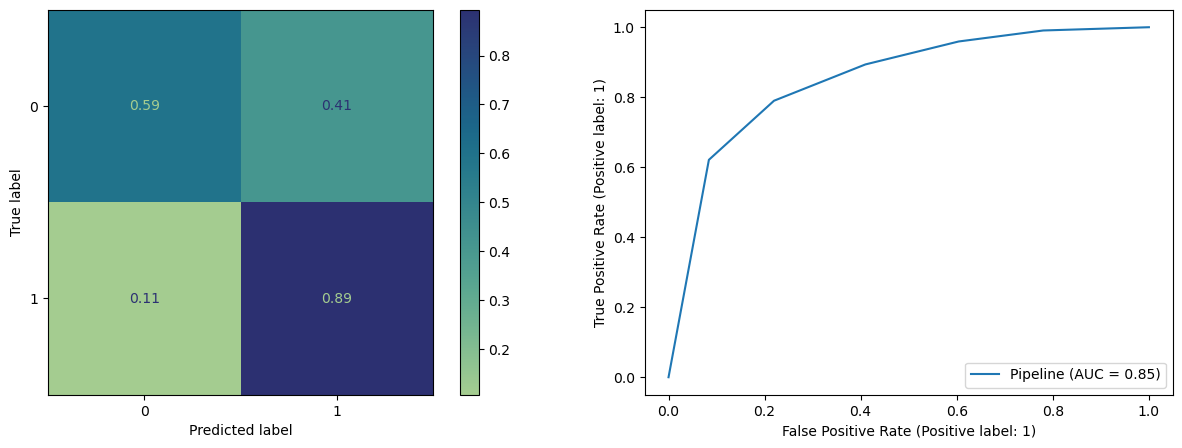

In [115]:
## Use the function twice to evaluate our model on training AND test data 
classification_metrics(knn_pipe, X_train,y_train,
                         cmap='Blues', label='Training Data')
classification_metrics(knn_pipe, X_test,y_test,
                         cmap='crest',label='Test Data')

#### With PCA

In [185]:
## Create a model pipeline with PCA and 10 principal components
knn_pipe_PCA = make_pipeline(preprocessor, PCA(n_components=10), knn)
## Fit the model
knn_pipe_PCA.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
                ('pca', PCA(n_components=10)),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      6678
           1       0.90      0.93      0.91     18410

    accuracy                           0.87     25088
   macro avg       0.84      0.82      0.83     25088
weighted avg       0.87      0.87      0.87     25088



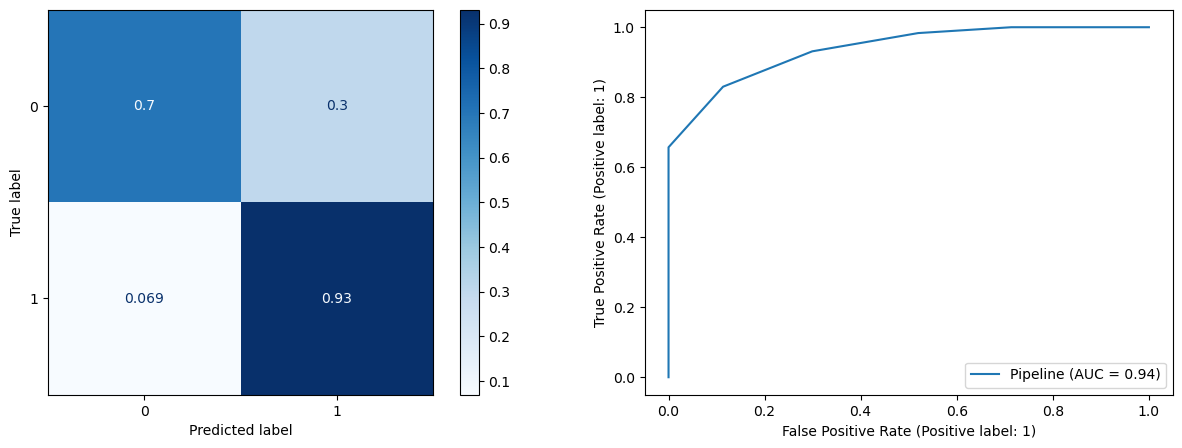

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      2250
           1       0.86      0.90      0.88      6113

    accuracy                           0.82      8363
   macro avg       0.77      0.75      0.76      8363
weighted avg       0.81      0.82      0.82      8363



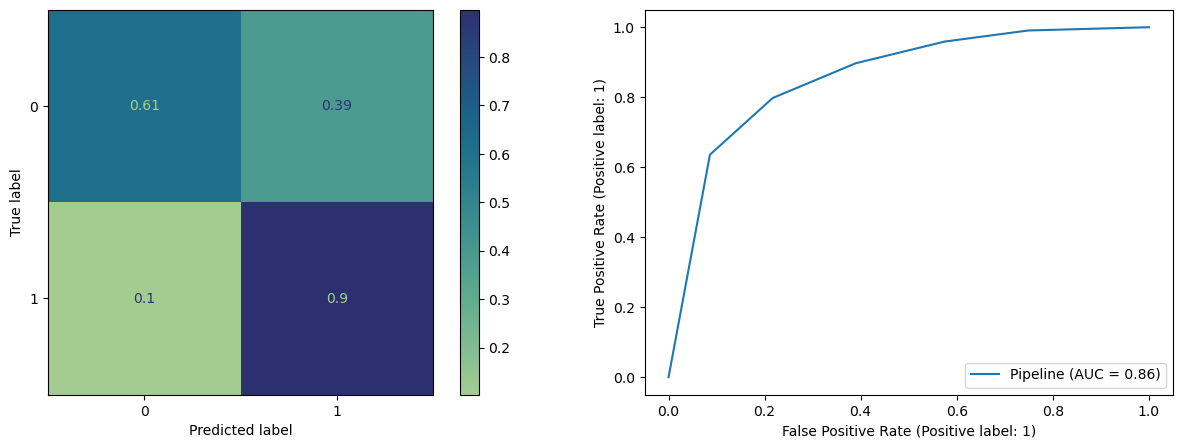

In [186]:
## Use the function twice to evaluate our model on training AND test data 
classification_metrics(knn_pipe_PCA, X_train,y_train,
                         cmap='Blues', label='Training Data')
classification_metrics(knn_pipe_PCA, X_test,y_test,
                         cmap='crest',label='Test Data')

#### GridSearch CV

In [187]:
knn_pipe_cv = make_pipeline(preprocessor, KNeighborsClassifier())
knn_pipe_cv.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                   ('cat',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False)),
                                                    ('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num', StandardScaler(),
                           

In [194]:
#creating the parameter grid for KNN GridSearchCV model and tuning n_neighbors, weights and algorithm
knn_range = range(3, 6)
knn_param_grid = {'kneighborsclassifier__n_neighbors': knn_range,
              'kneighborsclassifier__weights': ['uniform','distance'],
              'kneighborsclassifier__algorithm': ['auto','ball_tree', 'kd_tree', 'brute']}

In [195]:
#Creating GridSearchCV model, finding the best model on given parameters
knn_pipe_gs = GridSearchCV(knn_pipe_cv, knn_param_grid)

knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
knn_best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {knn_best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__algorithm': 'kd_tree', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best KNN model is: 0.8113117302403444


- After testing multiple ranges for the n_neighbors, `5` appears the be the best, I will be using that to tune the model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Best KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      6678
           1       0.90      0.93      0.91     18410

    accuracy                           0.87     25088
   macro avg       0.84      0.82      0.83     25088
weighted avg       0.87      0.87      0.87     25088



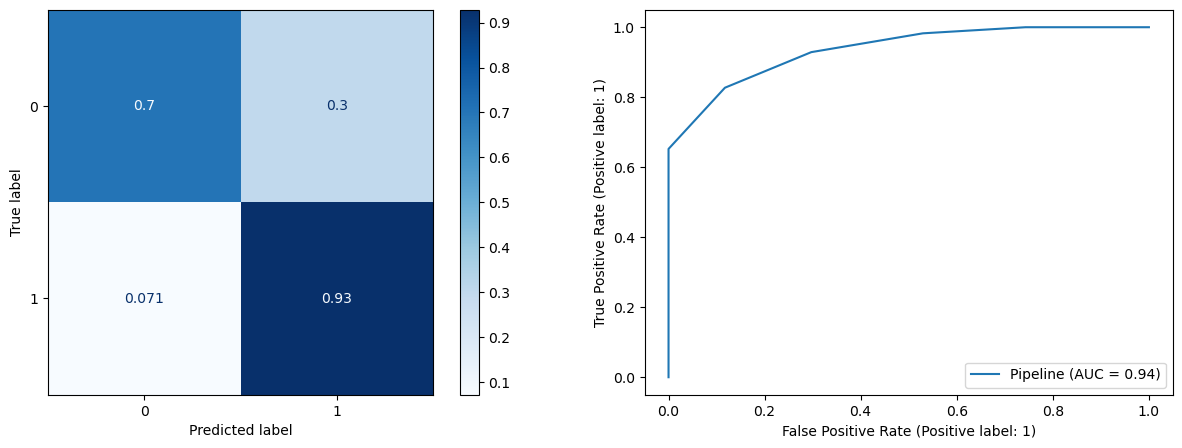

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Best KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      2250
           1       0.86      0.89      0.87      6113

    accuracy                           0.81      8363
   macro avg       0.76      0.74      0.75      8363
weighted avg       0.81      0.81      0.81      8363



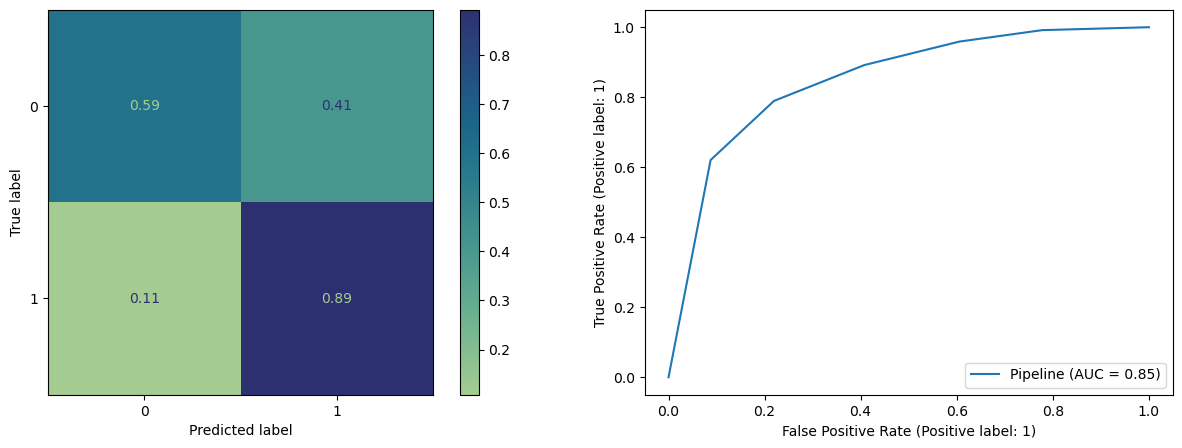

In [196]:
#Evaluating the Tuned Model using the classification_metrics function
classification_metrics(knn_best_pipe, X_train,y_train,
                         cmap='Blues', label='Best KNN Train Data')
classification_metrics(knn_best_pipe, X_test,y_test,
                         cmap='crest',label='Best KNN Test Data')

### Random Forest Model

#### Default Model

In [197]:
## Create an instance of the model
tree = RandomForestClassifier()
## Create a model pipeline
tree_pipe = make_pipeline(preprocessor, tree)
## Fit the model
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
                ('randomforestclassifier', RandomForestClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6678
           1       0.98      0.99      0.98     18410

    accuracy                           0.98     25088
   macro avg       0.97      0.97      0.97     25088
weighted avg       0.98      0.98      0.98     25088



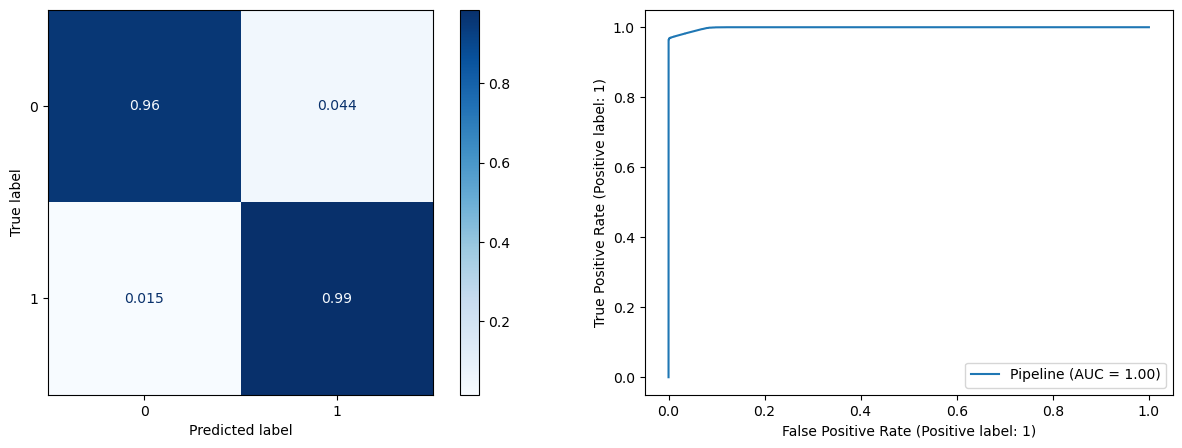

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      2250
           1       0.86      0.90      0.88      6113

    accuracy                           0.82      8363
   macro avg       0.77      0.75      0.76      8363
weighted avg       0.81      0.82      0.81      8363



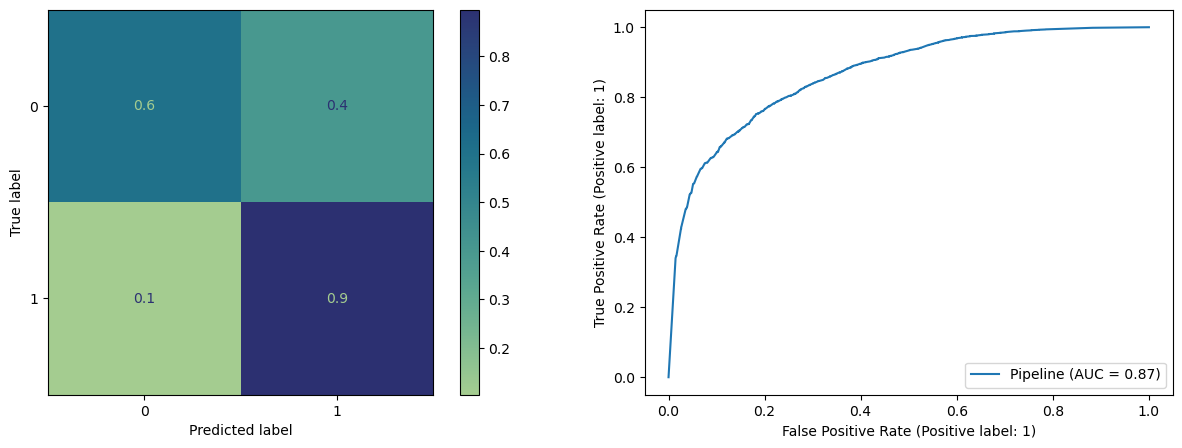

In [198]:
## Use the function twice to evaluate our model on training AND test data 
classification_metrics(tree_pipe, X_train,y_train,
                         cmap='Blues', label='Training Data')
classification_metrics(tree_pipe, X_test,y_test,
                         cmap='crest',label='Test Data')

#### With PCA

In [199]:
## Create a model pipeline with PCA and 10 principal components
tree_pipe_PCA = make_pipeline(preprocessor, PCA(n_components=10), tree)
## Fit the model
tree_pipe_PCA.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
                ('pca', PCA(n_components=10)),
                ('randomforestclassifier', RandomForestClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6678
           1       0.98      0.99      0.98     18410

    accuracy                           0.98     25088
   macro avg       0.97      0.97      0.97     25088
weighted avg       0.98      0.98      0.98     25088



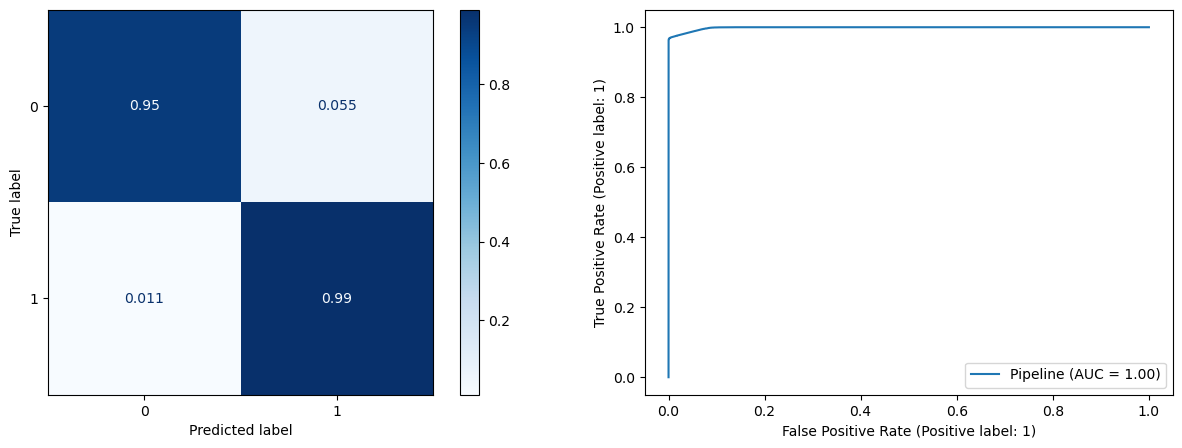

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      2250
           1       0.86      0.90      0.88      6113

    accuracy                           0.81      8363
   macro avg       0.77      0.74      0.75      8363
weighted avg       0.81      0.81      0.81      8363



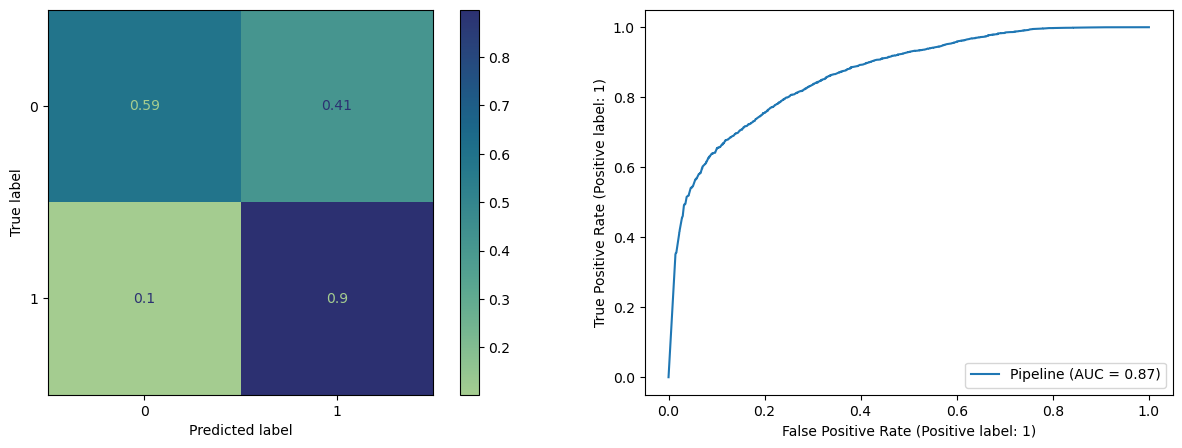

In [200]:
## Use the function twice to evaluate our model on training AND test data 
classification_metrics(tree_pipe_PCA, X_train,y_train,
                         cmap='Blues', label='Training Data')
classification_metrics(tree_pipe_PCA, X_test,y_test,
                         cmap='crest',label='Test Data')

#### GridSearch CV

In [201]:
tree_pipe_cv = make_pipeline(preprocessor, RandomForestClassifier())
tree_pipe_cv.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                   ('cat',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False)),
                                                    ('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num', StandardScaler(),
                       

In [210]:
#creating the parameter grid for Tree GridSearchCV model and tuning n_estimators, features and max depth
#Started with a range of 5 - 100, steps of 5 for tree_range, tweaking it as I run the following code to get the best tuned model
#Doing the same for the max_depth_range, began with a range of 5 - 25, steps of 5, and continuing to adjust based on output
tree_range = range(1,10)
max_depth_range = range(20,30)
tree_param_grid = {'randomforestclassifier__n_estimators': tree_range,
              'randomforestclassifier__max_features': ['sqrt', 'log2', None],
              'randomforestclassifier__max_depth': max_depth_range}

In [211]:
#Creating GridSearchCV model, finding the best model on given parameters
tree_pipe_gs = GridSearchCV(tree_pipe_cv, tree_param_grid)

tree_pipe_gs.fit(X_train, y_train)
print('Best Random Forest Parameters:')
print(tree_pipe_gs.best_params_)
tree_best_pipe = tree_pipe_gs.best_estimator_
print(f'Accuracy of best Random Forest model is: {tree_best_pipe.score(X_test, y_test)}')

Best Random Forest Parameters:
{'randomforestclassifier__max_depth': 21, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 9}
Accuracy of best Random Forest model is: 0.8382159512136793


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Best Tree Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      6678
           1       0.93      0.97      0.95     18410

    accuracy                           0.92     25088
   macro avg       0.92      0.88      0.90     25088
weighted avg       0.92      0.92      0.92     25088



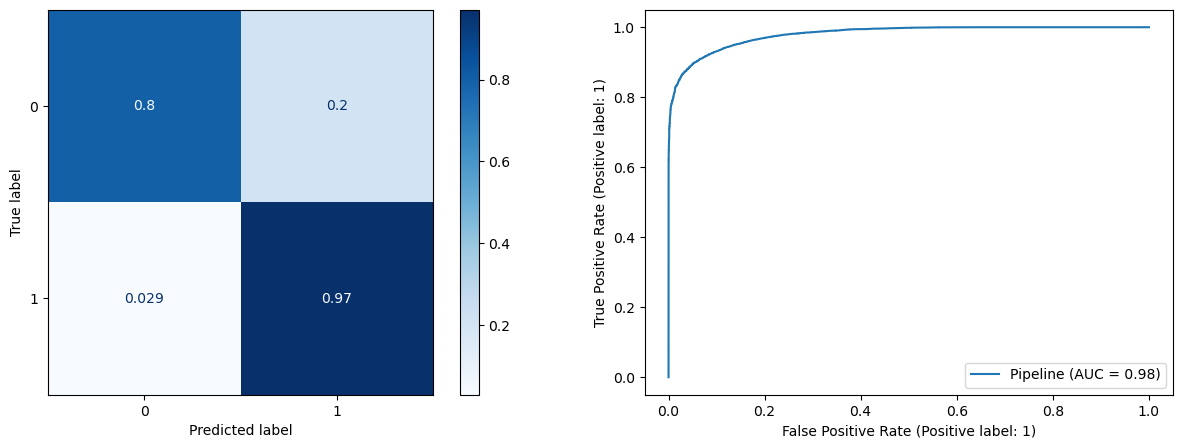

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Best Tree Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.61      0.67      2250
           1       0.87      0.92      0.89      6113

    accuracy                           0.84      8363
   macro avg       0.80      0.77      0.78      8363
weighted avg       0.83      0.84      0.83      8363



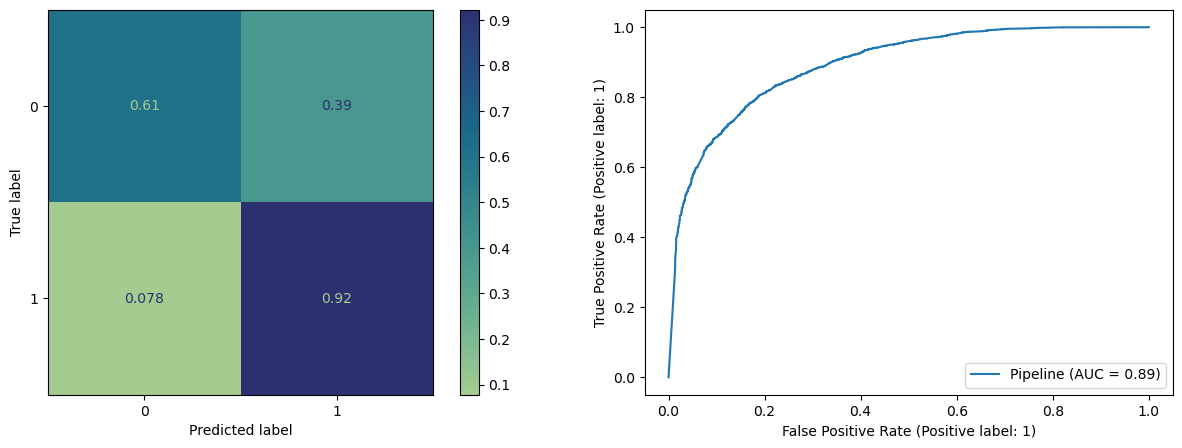

In [212]:
#Evaluating the Tuned Model using the classification_metrics function
classification_metrics(tree_best_pipe, X_train,y_train,
                         cmap='Blues', label='Best Tree Train Data')
classification_metrics(tree_best_pipe, X_test,y_test,
                         cmap='crest',label='Best Tree Test Data')

### ADA Boosted Model

#### Default Model

In [213]:
from sklearn.ensemble import AdaBoostClassifier

In [214]:
## Create an instance of the model
ada = AdaBoostClassifier()
## Create a model pipeline
ada_pipe = make_pipeline(preprocessor, ada)
## Fit the model
ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
                ('adaboostclassifier', AdaBoostClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.61      0.68      6678
           1       0.87      0.93      0.90     18410

    accuracy                           0.85     25088
   macro avg       0.82      0.77      0.79     25088
weighted avg       0.84      0.85      0.84     25088



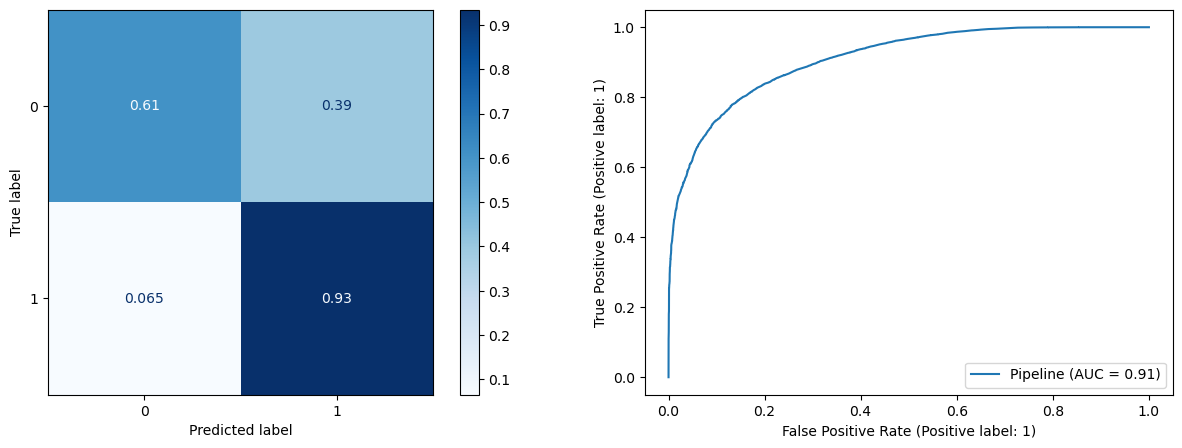

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.62      0.69      2250
           1       0.87      0.94      0.90      6113

    accuracy                           0.85      8363
   macro avg       0.83      0.78      0.80      8363
weighted avg       0.85      0.85      0.85      8363



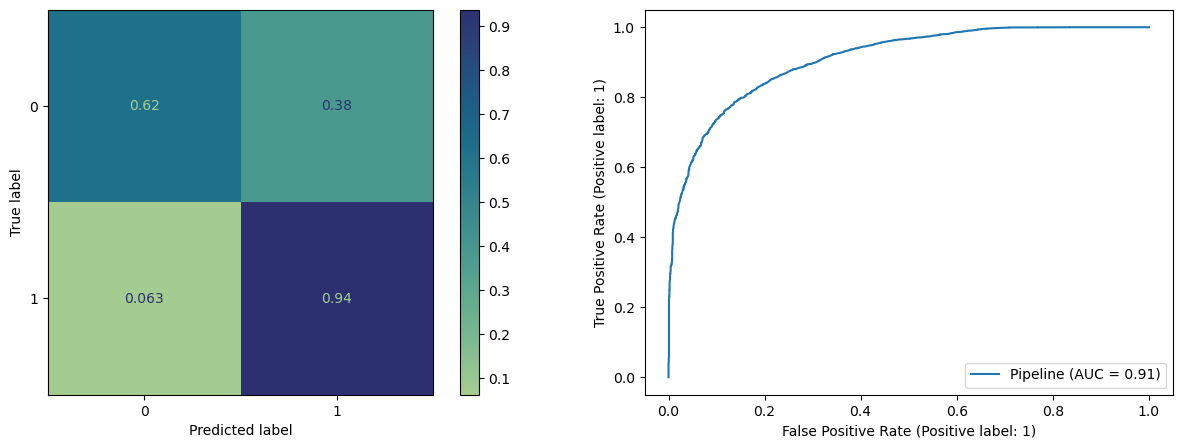

In [215]:
#Evaluating the Boosted Model using the classification_metrics function
classification_metrics(ada_pipe, X_train,y_train,
                         cmap='Blues', label='Train Data')
classification_metrics(ada_pipe, X_test,y_test,
                         cmap='crest',label='Test Data')

#### With PCA

In [216]:
## Create a model pipeline with PCA and 10 principal components
ada_pipe_PCA = make_pipeline(preprocessor, PCA(n_components=10), ada)
## Fit the model
ada_pipe_PCA.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
                ('pca', PCA(n_components=10)),
                ('adaboostclassifier', AdaBoostClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      6678
           1       0.87      0.91      0.89     18410

    accuracy                           0.83     25088
   macro avg       0.79      0.77      0.78     25088
weighted avg       0.83      0.83      0.83     25088



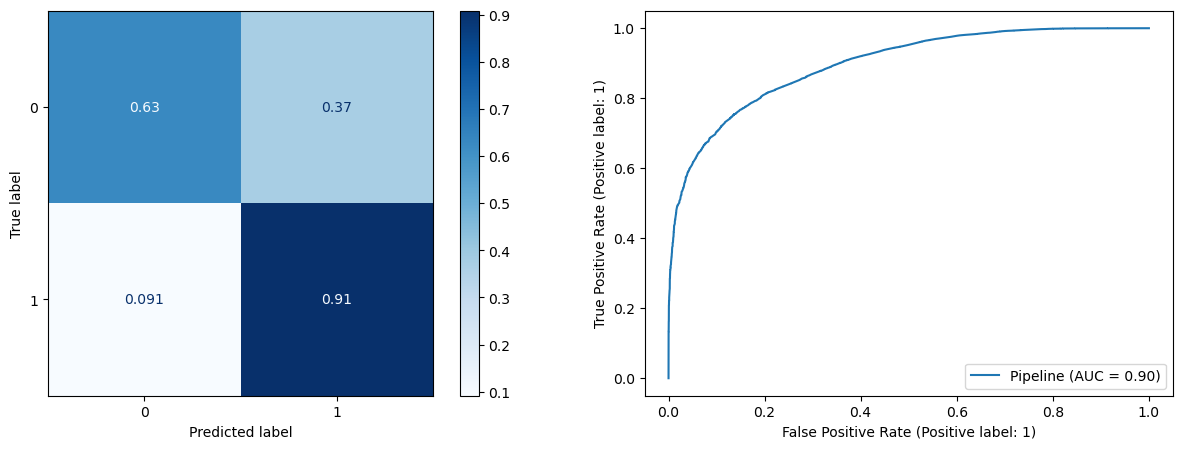

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.63      0.68      2250
           1       0.87      0.91      0.89      6113

    accuracy                           0.84      8363
   macro avg       0.80      0.77      0.79      8363
weighted avg       0.83      0.84      0.84      8363



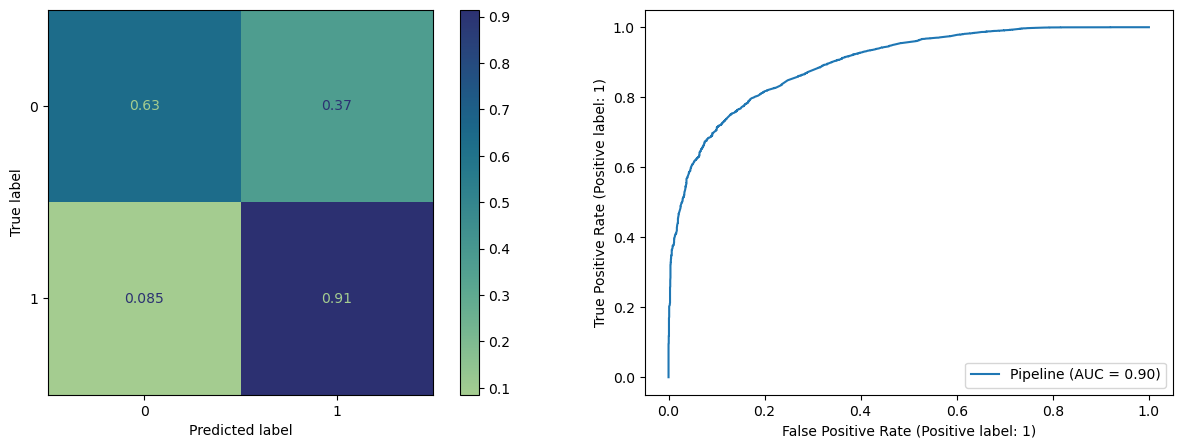

In [217]:
## Use the function twice to evaluate our model on training AND test data 
classification_metrics(ada_pipe_PCA, X_train,y_train,
                         cmap='Blues', label='Training Data')
classification_metrics(ada_pipe_PCA, X_test,y_test,
                         cmap='crest',label='Test Data')

#### Grid Search CV

In [227]:
ada_pipe_cv = make_pipeline(preprocessor, AdaBoostClassifier())
ada_pipe_cv.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD01650D0>),
                                   ('cat',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False)),
                                                    ('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CAD88ECA60>)])),
  ('adaboostclassifier', AdaBoostClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num', StandardScaler(),
                               

In [232]:
#creating the parameter grid for Ada Boosting model and tuning n_estimators and learning rate

ada_param_grid = {
        'adaboostclassifier__n_estimators': [250, 300, 350],
        'adaboostclassifier__learning_rate': [1.0, 1.5, 2.0],
}

In [233]:
#Creating GridSearchCV model, finding the best model on given parameters
ada_pipe_gs = GridSearchCV(ada_pipe_cv, ada_param_grid)

ada_pipe_gs.fit(X_train, y_train)
print('Best Ada Boosted Parameters:')
print(ada_pipe_gs.best_params_)
ada_best_pipe = ada_pipe_gs.best_estimator_
print(f'Accuracy of best Ada Boosted model is: {ada_best_pipe.score(X_test, y_test)}')

Best Ada Boosted Parameters:
{'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 300}
Accuracy of best Ada Boosted model is: 0.8626091115628363


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Best Ada Boost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.65      0.71      6678
           1       0.88      0.93      0.91     18410

    accuracy                           0.86     25088
   macro avg       0.83      0.79      0.81     25088
weighted avg       0.85      0.86      0.85     25088



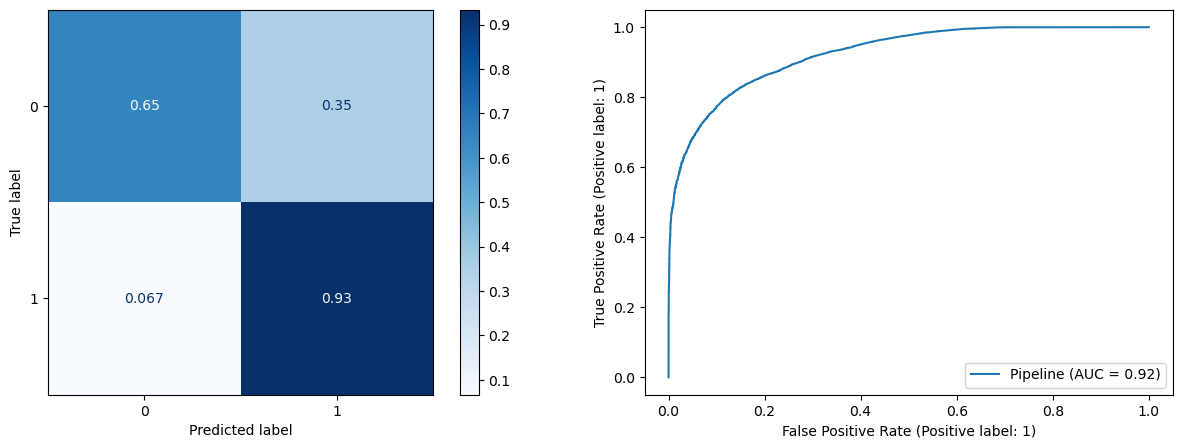

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Best Ada Boost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.67      0.72      2250
           1       0.88      0.93      0.91      6113

    accuracy                           0.86      8363
   macro avg       0.84      0.80      0.82      8363
weighted avg       0.86      0.86      0.86      8363



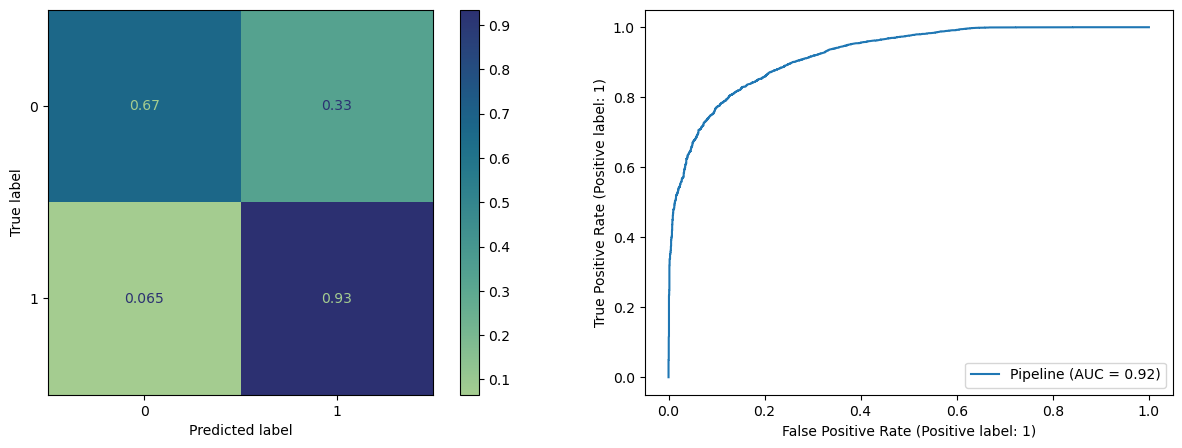

In [234]:
#Evaluating the Tuned Model using the classification_metrics function
classification_metrics(ada_best_pipe, X_train,y_train,
                         cmap='Blues', label='Best Ada Boost Train Data')
classification_metrics(ada_best_pipe, X_test,y_test,
                         cmap='crest',label='Best Ada Boost Test Data')

### Production Model Choice

- The final production model with the best stats would be the tuned **Ada Boosted model**
- It had the highest overall accuracy with `86%`
- The greatest percentage of True Positives with `93%`
- The greatest percentage of True Negatives with `67%`
- The lowest False Negatives with `6.5%` and False Positives with `33%`